# Lithospheric Convergence Model
#### Ben Knight
###### Monash University

In [1]:
import underworld as uw
import underworld.function as fn
import UWGeodynamics as GEO
import os
from datetime import datetime
import pytz
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import underworld.visualisation as visualisation

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


### Erosion functions

In [2]:
from UW2DsurfaceProcesses import diffusiveSurfaceErosion, velocitySurfaceErosion

In [3]:
u = GEO.UnitRegistry

GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2
GEO.rcParams['initial.nonlinear.max.iterations'] = 50

GEO.rcParams["nonlinear.tolerance"] = 1e-2
GEO.rcParams['nonlinear.max.iterations'] = 50

GEO.rcParams["popcontrol.particles.per.cell.2D"] = 30
GEO.rcParams["swarm.particles.per.cell.2D"] = 30

In [4]:
restart = False

### Values to change

In [5]:
conv_vel = 5.
crustalthickness = 25.0

crust_transition = 500.0
Update_material_LHS_Length = 200.0

### Setup of box

In [6]:
u = GEO.UnitRegistry

Sticky_air = 30.0
x_box = 1000.0
y_box = 250.0 - Sticky_air


Depth_of_box = y_box * u.kilometer
model_length = x_box * u.kilometer

x_res  = 2**7 
y_res =  2**5


resolution = (x_box/x_res)


In [7]:
# Total_Convergence = 600.0
Total_Time = 10.0 #Total_Convergence / (10*conv_vel)
The_Checkpoint_interval = 1.0 #Total_Time / 40.

In [8]:
if uw.mpi.rank == 0:
    print(x_res,y_res)
    print(Total_Time)
    print(The_Checkpoint_interval)
    
uw.mpi.barrier()



128 32
10.0
1.0


## Scaling

In [9]:
half_rate = 1. * u.centimeter / u.year
length_scale = 300.0 * u.kilometer
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1573.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = length_scale
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT



### Scaling
if uw.mpi.rank == 0:
    print('Length, km = ', GEO.dimensionalise(1., u.kilometer))
    print('Time, Myr = ',GEO.dimensionalise(1., u.megayear))
    print('Pressure, MPa = ',GEO.dimensionalise(1., u.megapascal))
    print('Temperature, K = ',GEO.dimensionalise(1., u.degK))
    print('Velocity, cm/yr = ',GEO.dimensionalise(1., u.centimeter / u.year))
    print('Viscosity, Pa S = ',GEO.dimensionalise(1.,u.pascal * u.second))

Length, km =  300.0 kilometer
Time, Myr =  30.0 megayear
Pressure, MPa =  9711.899999999998 megapascal
Temperature, K =  1300.0 kelvin
Velocity, cm/yr =  1.0 centimeter / year
Viscosity, Pa S =  9.194331281210667e+24 pascal * second


# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [10]:
Model = GEO.Model(elementRes=(x_res, y_res),
                  minCoord=(0. * u.kilometer, -1.*Depth_of_box),
                  maxCoord=(model_length, Sticky_air * u.kilometer),
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [11]:
today = datetime.now(pytz.timezone('Australia/Melbourne'))
if restart == False:
    Model.outputDir = os.path.join(str(crustalthickness) + 'km-CT_Erosion-LR_' + str(conv_vel) + "cmyr_"  + today.strftime('%Y-%m-%d_%H-%M') + "/")

    directory = os.getcwd() +'/'+ Model.outputDir

if restart == True:
    RestartDirectory = os.getcwd()
    directory = RestartDirectory

# Add some additional swarm/mesh variables

In [12]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

# Add some Materials

In [13]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))

In [14]:
## Upper crust
crust1 = Model.add_material(name="Crust1")
crust2 = Model.add_material(name="Crust2")
crust3 = Model.add_material(name="Crust3")
crust4 = Model.add_material(name="Crust4")

## create a layered crust

In [15]:
Fault_positionX = crust_transition * u.kilometer
### creates a layer every 5 km
sin_function = np.sign(np.sin(GEO.dimensionalise(Model.swarm.data[:,1], u.kilometer)/(1.6 * u.kilometer)))

Model.materialField.data[(sin_function>0) & (Model.swarm.data[:,0] < GEO.nd(Fault_positionX+15.*u.kilometer)) &  (Model.swarm.data[:,1] < GEO.nd(0.*u.kilometer))] = crust1.index
Model.materialField.data[(sin_function<0) & (Model.swarm.data[:,0] < GEO.nd(Fault_positionX+15.*u.kilometer)) &  (Model.swarm.data[:,1] < GEO.nd(0.*u.kilometer))] = crust2.index

Model.materialField.data[(sin_function>0) & (Model.swarm.data[:,0] >= GEO.nd(Fault_positionX+15.*u.kilometer)) &  (Model.swarm.data[:,1] < GEO.nd(0.*u.kilometer))] = crust3.index
Model.materialField.data[(sin_function<0) & (Model.swarm.data[:,0] >= GEO.nd(Fault_positionX+15.*u.kilometer)) &  (Model.swarm.data[:,1] < GEO.nd(0.*u.kilometer))] = crust4.index

In [16]:
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=-crustalthickness* u.kilometer, bottom=-100.0 * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))

In [17]:
Sediment = Model.add_material(name="Sediment")    

### Material physical properties

In [18]:
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [19]:
air.density = 1. * u.kilogram / u.metre**3
mantleLithosphere.density = GEO.LinearDensity(3300. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantle.density = GEO.LinearDensity(3300. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)


mantleLithosphere.radiogenicHeatProd = 0.00 * u.microwatt / u.meter**3
mantle.radiogenicHeatProd = 0.00 * u.microwatt / u.meter**3

In [20]:
crust1.radiogenicHeatProd = 0. * u.microwatt / u.meter**3
crust2.radiogenicHeatProd = 0. * u.microwatt / u.meter**3
crust3.radiogenicHeatProd = 0. * u.microwatt / u.meter**3
crust4.radiogenicHeatProd = 0. * u.microwatt / u.meter**3


crust1.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
crust2.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
crust3.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
crust4.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)

Sediment.density = GEO.LinearDensity(2600. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
Sediment.radiogenicHeatProd = 0. * u.microwatt / u.meter**3

In [21]:
angle_D = 45 # in degrees
Fault_PositionX_LAB = Fault_positionX + ((mantleLithosphere.top - mantleLithosphere.bottom) * math.tan(math.radians(angle_D)))

FaultShape = GEO.shapes.Polygon(vertices=[(Fault_positionX, mantleLithosphere.top),
                                        (Fault_positionX + 35.* u.kilometer, mantleLithosphere.top),
                                        (Fault_PositionX_LAB+3.5* u.kilometer, mantleLithosphere.bottom),
                                         (Fault_PositionX_LAB, mantleLithosphere.bottom)])

Fault = Model.add_material(name="Fault", shape=FaultShape)
Fault.radiogenicHeatProd = 0.00 * u.microwatt / u.meter**3
Fault.density  = GEO.LinearDensity(reference_density=3300. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)


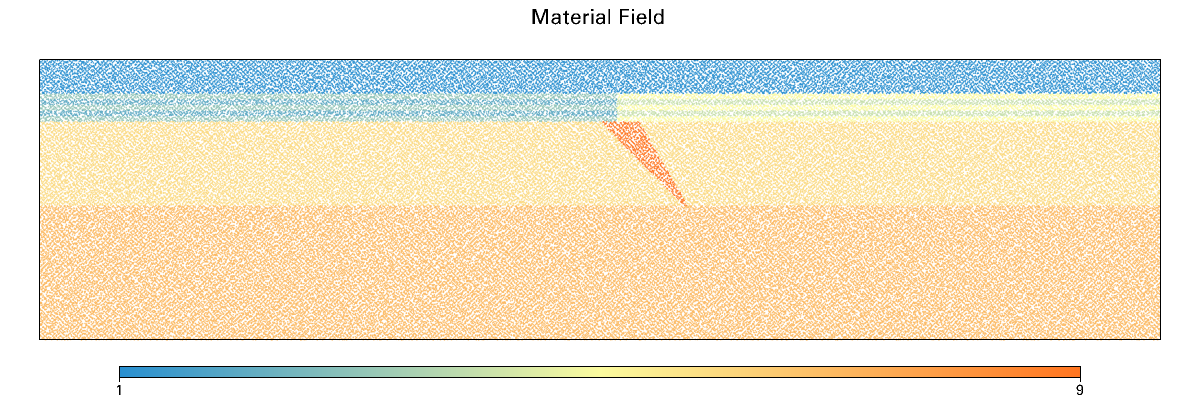

In [22]:
Fig = visualisation.Figure(figsize=(1200,400), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [23]:
rh = GEO.ViscousCreepRegistry()

In [24]:
combined_viscosity_mantle = GEO.CompositeViscosity([rh.Dry_Olivine_Diffusion_Hirth_and_Kohlstedt_2003, rh.Dry_Olivine_Dislocation_Hirth_and_Kohlstedt_2003])
combined_viscosity_fault = GEO.CompositeViscosity([rh.Wet_Olivine_Diffusion_Hirth_and_Kohlstedt_2003, rh.Wet_Olivine_Dislocation_Hirth_and_Kohlstedt_2003])

In [25]:
Model.minViscosity = 1e19 * u.pascal * u.second
Model.maxViscosity = 1e24 * u.pascal * u.second

air.viscosity                = 1e19 * u.pascal * u.second


mantleLithosphere.viscosity  = combined_viscosity_mantle
mantle.viscosity             = combined_viscosity_mantle

Fault.viscosity              = combined_viscosity_fault


### Crust
crust1.viscosity              = rh.Wet_Quartz_Dislocation_Tullis_et_al_2002
crust2.viscosity              = rh.Wet_Quartz_Dislocation_Tullis_et_al_2002
crust3.viscosity              = rh.Wet_Quartz_Dislocation_Tullis_et_al_2002
crust4.viscosity              = rh.Wet_Quartz_Dislocation_Tullis_et_al_2002

Sediment.viscosity            = rh.Wet_Quartz_Dislocation_Tullis_et_al_2002

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [26]:
pl = GEO.PlasticityRegistry()

In [27]:
Weak_crust_plasticity =  GEO.DruckerPrager(cohesion=10.* u.megapascal,
                                     cohesionAfterSoftening=1.*u.megapascal,
                                     frictionCoefficient=0.3,
                                     frictionAfterSoftening=0.15,
                                     epsilon1=0.5, epsilon2=1.5)
Sediment_plasticity =  GEO.DruckerPrager(cohesion=10.* u.megapascal,
                                     cohesionAfterSoftening=1.*u.megapascal,
                                     frictionCoefficient=0.3,
                                     frictionAfterSoftening=0.15,
                                     epsilon1=0.5, epsilon2=1.5)



Mantle_plasticity =  GEO.DruckerPrager(cohesion=10.* u.megapascal,
                                     cohesionAfterSoftening=10.*u.megapascal,
                                     frictionCoefficient=0.6,
                                     frictionAfterSoftening=0.6,
                                     epsilon1=0.5, epsilon2=1.5)

Fault_plasticity = GEO.DruckerPrager(cohesion=10.* u.megapascal,
                                     cohesionAfterSoftening=1.*u.megapascal,
                                     frictionCoefficient=0.1,
                                     frictionAfterSoftening=0.05,
                                     epsilon1=0.5, epsilon2=1.5)

In [28]:
mantleLithosphere.plasticity  = Mantle_plasticity
mantle.plasticity             = Mantle_plasticity
Fault.plasticity              = Fault_plasticity

In [29]:
crust1.plasticity              = Weak_crust_plasticity
crust2.plasticity              = Weak_crust_plasticity
crust3.plasticity              = Weak_crust_plasticity
crust4.plasticity              = Weak_crust_plasticity


Sediment.plasticity            = Sediment_plasticity

## Temperature Boundary Conditions

In [30]:
Model.set_temperatureBCs(top=273.15 * u.degK, 
                         bottom=1573.15 * u.degK,
                         materials=[(air, 273.15 * u.degK)])

## Velocity Boundary Conditions

In [31]:
Model.velocityField.data[:] = 0.

In [32]:
def UpdateVelocity():
    global conv_vel 
    
    conv_vel = conv_vel * u.centimeter/u.year

    conditionsA = [(Model.y < GEO.nd(0. * u.kilometre), GEO.nd(conv_vel)),
                   (True, GEO.nd(conv_vel) + Model.y * (GEO.nd((-2. * conv_vel) / GEO.nd(Sticky_air * u.kilometer))))]


    Left_wall_vel_top_changed = fn.branching.conditional(conditionsA)

## Test air boundary condition on side wall


    conditionsB = [(Model.y > GEO.nd(mantleLithosphere.bottom), Left_wall_vel_top_changed),
                   (True, (GEO.nd(conv_vel) + (Model.y-GEO.nd(mantleLithosphere.bottom)) * (GEO.nd(conv_vel) / GEO.nd(Depth_of_box+mantleLithosphere.bottom))))]


    Left_wall_vel = fn.branching.conditional(conditionsB)


    Model.set_velocityBCs(left = [Left_wall_vel, None],
                      right=[0., None],
                      top = [None, 0.],
                        bottom = [None, None])


UpdateVelocity()




### Grid Tracers

In [33]:
x_c, y_c = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], mantleLithosphere.top], 
                    maxCoord=[Model.maxCoord[0], 0.*u.kilometer])

FSE_Crust = Model.add_passive_tracers(name="FSE_Crust", vertices=[x_c, y_c])

FSE_Crust.add_tracked_field(Model.pressureField,
                              name="tracers_press",
                              units=u.megapascal,
                              dataType="double")

FSE_Crust.add_tracked_field(Model.temperature,
                              name="tracers_temp",
                              units=u.degK,
                              dataType="double")

FSE_Crust.add_tracked_field(Model.strainRate_2ndInvariant,
                              name="tracers_SR",
                                units=1./u.second,
                              dataType="double")



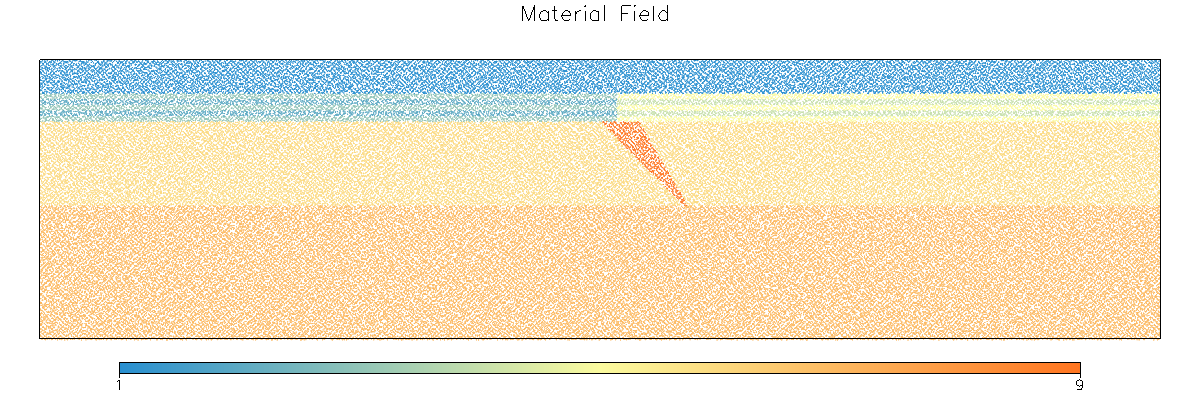

In [34]:
Fig = visualisation.Figure(figsize=(1200,400), title="Material Field", quality=0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

Viscous dissipation calc on the swarm and mesh, for integration over the crust area

# Compute initial condition

In [35]:
Model.init_model()

In [36]:
### Custom temp gradient

for index, coord in enumerate(Model.mesh.data):
### Temperature in air
    if coord[1] > 0.:
        T = (273.15 * u.kelvin)
    #### Temperature across top 10 km of crust
    elif coord[1] < 0. and coord[1] >= GEO.nd(-10*u.kilometer):
            T = (273.15 * u.kelvin + (-1*GEO.dimensionalise(coord[1], u.kilometer) * 25. * u.kelvin/u.kilometer))
    #### Temperature for the lower crust and lithosphere
    elif coord[1] < GEO.nd(-10*u.kilometer) and coord[1] >= GEO.nd(mantleLithosphere.bottom):
            T = ((273.15+130.0) * u.kelvin + (-1*GEO.dimensionalise(coord[1], u.kilometer) * 12. * u.kelvin/u.kilometer))
#### Temperature for the Upper Mantle
    elif coord[1] < GEO.nd(mantleLithosphere.bottom):
        T = 1573.15* u.degK 

    Model.temperature.data[index] = GEO.nd(T)
    

### Surface processes

In [37]:
# Model.surfaceProcesses = diffusiveSurfaceErosion(
#     airIndex=air.index,
#     sedimentIndex=Sediment.index,
#     D= 100.0*u.meter**2/u.year,
#     dx=5 * u.kilometer,
#     surfaceElevation=air.bottom
# )

In [38]:
Model.surfaceProcesses = velocitySurfaceErosion(
    airIndex=air.index,
    sedimentIndex=Sediment.index,
    sedimentationRate= 1.0*u.millimeter / u.year,
    erosionRate= 0.5*u.millimeter / u.year,
    dx=5 * u.kilometer,
    surfaceElevation=0.0*u.kilometer
)

### Additional stuff at checkpointing

In [39]:
Model.solver.set_inner_method("mg")
Model.solver.set_penalty(1e-3)

# Run the Model

In [40]:
if restart == True:
    Model.run_for(Total_Time * u.megayears, checkpoint_interval=The_Checkpoint_interval*u.megayears, restartStep=-1, restartDir=RestartDirectory)
else:   
    Model.run_for(Total_Time * u.megayears, checkpoint_interval=The_Checkpoint_interval*u.megayears)
    
    
    

Running with UWGeodynamics version 2.9.5
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-05 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
total time: 40872.19935080194 timestep: 10218.049837700484 No. of its: 4
finished surface process on global rank: 0
Step:     1 Model Time: 40872.2 year dt: 40872.2 year (2020-08-11 03:06:08)
total time: 69308.59998602452 timestep: 17327.14999650613 No. of its: 4
finished surface process on global rank: 0
Step:     2 Model Time: 110180.8 year dt: 69308.6 year (2020-08-11 03:06:18)
total time: 71873.79729233625 timestep: 17968.449323084064 No. of its: 4
finished surface process on global rank: 0
Step:     3 Model Time: 182054.6 year dt: 71873.8 year (2020-08-11 03:06:24)
total time: 66987.03451308652 timestep: 16746.75862827163 No

KeyboardInterrupt: 